In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time, timedelta
import ast
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

## 1. Introduction & Dataset Overview  

ACCRE staff have hypothesized that the job scheduler sometimes becomes unresponsive because it is processing large bursts of job completions. This especially affects automated job submitters, such as members of the Open Science Grid.

This project is meant to evaluate whether the data supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness.

This project makes use of three datasets:  
* fullsample.csv: Contains slurm job records. Job completions correspond to jobs in the "COMPLETED" state with exit code "0:0".  
* slurm_wrapper_ce5.log, slurm_wrapper_ce6.log: These log files contain every slurm command executed by the CE5 and CE6 servers (gateways to the Open Science Grid).  
Unresponsive periods are indicated by "sbatch" commands from user 9204 that have:  
    * return code = 1
    * execution time > 15 seconds

## 2. Data Exploration & Cleaning  

### Full sample data (Slurm job records)

The fullsample dataset contains job records, with one row per job. Each job gets a unique ID, contained in the JOBID column.

Some jobs can be submitted as arrays of similar jobs. These are listed with an underscore in the JOBID, where the number after the underscore indicates the tasknumber.

We have data for 7,395,885 total jobs (or job parts).

##### Code:

In [2]:
jobs = pd.read_csv("../data/fullsample.csv")
jobs.head(5)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0


In [3]:
jobs.shape[0]

7395885

##### The full sample dataset contains the following columns: 

| Column | Description |
|---|---|
| **JOBID** | The identification number of the job or job step. Array jobs are in the form ArrayJobID_ArrayTaskID.  | 
| **STATE** | Job state or status (COMPLETED, CANCELLED, FAILED, TIMEOUT, PREEMPTED, etc.). | 
| **BEGIN** | Beginning time for the job (may be different from the submit time). |
| **END** | Ending time for the job.     |
| **REQMEM** | Requested memory in megabytes. May be per-core (Mc) or per-node (Mn).   |
| **USEDMEM** | Used memory in megabytes per-node.   |
| **REQTIME** | Requested time in d-hh:mm:ss or hh:mm:ss.   |
| **USEDTIME** | Used time in d-hh:mm:ss or hh:mm:ss.   |
| **NODES** | Number of servers used for this job.   |
| **CPUS** | Total number of CPU-cores allocated to the job.   |
| **PARTITION** | Identifies the partition on which the job ran.    |
| **EXITCODE** | The exit code returned by the job script or salloc, typically as set by the exit() function. Following the colon is the signal that caused the process to terminate if it was terminated by a signal.    |

##### Code:

In [4]:
jobs.columns

Index(['JOBID', 'STATE', 'BEGIN', 'END', 'REQMEM', 'USEDMEM', 'REQTIME',
       'USEDTIME', 'NODES', 'CPUS', 'PARTITION', 'EXITCODE'],
      dtype='object')

##### We see that each row in the dataset contains a unique job (or job part).

##### Code:

In [5]:
(jobs['JOBID'].value_counts()>1).sum()

np.int64(0)

##### Most jobs ran on 1, 2, 3, or 8 nodes. There are a few outlier jobs that ran on 200 and 500 nodes.

##### Code:

In [6]:
jobs['NODES'].value_counts().reset_index().sort_values(by='NODES')

,NODES,count
0,1,7385963
1,2,3525
2,3,2716
4,4,860
6,5,217
...,...,...
64,138,1
69,150,1
68,180,1
47,200,2


##### Most jobs ran on the "production", "nogpfs", or "pascal" partitions. The "debug" and "sam" partitions are test jobs that are expected to be short, and the "maxwell", "pascal", and "turing" partitions are for GPU resources.

##### Code:

In [7]:
jobs['PARTITION'].value_counts()

PARTITION
production              7019578
nogpfs                   147229
pascal                   124453
sam                       64967
turing                    21424
maxwell                   11278
cgw-maizie                 4309
debug                      1616
cgw-platypus                379
cgw-dsi-gw                  228
cgw-capra1                  157
cgw-dougherty1              125
cgw-horus                    61
cgw-cqs1                     28
cgw-hanuman                  21
cgw-sideshowbob              14
cgw-vm-qa-flatearth1          9
cgw-tbi01                     8
cgw-rocksteady                1
Name: count, dtype: int64

##### Most jobs are in the 'COMPLETED' state, with an exit code of 0:0. The next most common states are 'CANCELLED' and 'FAILED'. Also note that there are 208 running jobs and 443 pending jobs.

We also see many states of the form 'CANCELLED by \<number\>', where '\<number\>' might refer to a user ID.

##### Code:

In [8]:
jobs.groupby(['STATE','EXITCODE'])['JOBID'].count()

STATE          EXITCODE
CANCELLED      0:0         5378
               0:11          35
               0:15        1886
               0:40           1
               0:6           18
                           ... 
FAILED         9:0            3
NODE_FAIL      1:0            2
OUT_OF_MEMORY  0:125       1739
PENDING        0:0          443
RUNNING        0:0          208
Name: JOBID, Length: 227, dtype: int64

##### Note that all 'RUNNING' jobs have an 'END' of 'Unknown'.

##### Code:

In [9]:
jobs[jobs['STATE']=='RUNNING'].head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
7343,31874232_1949,RUNNING,2021-08-31T23:55:05,Unknown,2048Mn,0,00:15:00,36-20:34:17,1,1,production,0:0
7650,31874232_2461,RUNNING,2021-08-31T23:58:07,Unknown,2048Mn,144.11M,00:15:00,36-20:31:15,1,1,production,0:0
7676,31874232_2487,RUNNING,2021-08-31T23:58:07,Unknown,2048Mn,0,00:15:00,36-20:31:15,1,1,production,0:0
8621,31874232_3432,RUNNING,2021-09-01T00:03:07,Unknown,2048Mn,0,00:15:00,36-20:26:15,1,1,production,0:0


In [10]:
jobs[jobs['STATE']=='RUNNING']['END'].nunique()

1

##### Note that all 'PENDING' jobs have both a 'BEGIN' and an 'END' of 'Unknown' and a 'USEDTIME' of 00:00:00.

##### Code:

In [11]:
jobs[jobs['STATE']=='PENDING'].head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
830993,31940830,PENDING,Unknown,Unknown,251904Mn,0,13-18:00:00,00:00:00,1,16,production,0:0
923853,32808176,PENDING,Unknown,Unknown,81920Mn,0,3-00:00:00,00:00:00,1,2,production,0:0
923922,32907807_430,PENDING,Unknown,Unknown,16384Mn,0,2-02:00:00,00:00:00,1,1,production,0:0
923923,32907807_311,PENDING,Unknown,Unknown,16384Mn,0,2-02:00:00,00:00:00,1,1,production,0:0
923924,32907807_325,PENDING,Unknown,Unknown,16384Mn,0,2-02:00:00,00:00:00,1,1,production,0:0


In [12]:
jobs[jobs['STATE']=='PENDING'][['BEGIN','END','USEDTIME']].nunique()

BEGIN       1
END         1
USEDTIME    1
dtype: int64

##### Furthermore, we see that any job with 'Unknown' as the 'BEGIN' or 'END' is in either a 'PENDING' or 'RUNNING' state.

##### Code:

In [13]:
jobs[(jobs['BEGIN'] == 'Unknown') | (jobs['END'] == 'Unknown')].value_counts('STATE')

STATE
PENDING    443
RUNNING    208
Name: count, dtype: int64

##### We see that some jobs have small discrepancies in the USEDTIME when compared to the value of the end time minus the begin time. Other jobs even have an end time that is before the begin time. 

##### Code:

In [14]:
# Check data integrity for the 'USEDTIME' column. It should equal 'END' minus 'BEGIN'

# Create a new dataframe with just the begin, end, and usedtime times for jobs that have a begin and end time
job_times = jobs[(jobs['BEGIN'] != 'Unknown') & (jobs['END'] != 'Unknown')][['JOBID','BEGIN','END','USEDTIME']]

# Convert 'END' and 'BEGIN' to datetime
job_times['BEGIN'] = pd.to_datetime(job_times['BEGIN'], format = "%Y-%m-%dT%H:%M:%S")
job_times['END'] = pd.to_datetime(job_times['END'], format = "%Y-%m-%dT%H:%M:%S")

# Manually calculate time difference between 'BEGIN' and 'END' for each row and assign to a new 'USEDTIME_MANUAL' column
# Clean up the output by replacing ' days ' with a dash, and remove leading '0-' if it is present
usedtime_manual = [(str(diff)).replace(' days ', '-') for diff in (job_times['END'] - job_times['BEGIN'])]
usedtime_manual_cleaned = [value.replace('0-','') if value[:2]=='0-' else value for value in usedtime_manual]
job_times['USEDTIME_MANUAL'] = usedtime_manual_cleaned

# Find instances where the manually calculated usedtime matches the value of 'USEDTIME
usedtime_equ = job_times['USEDTIME_MANUAL'] == job_times['USEDTIME']

# Find any rows with inconsistent 'USEDTIME' values and filter them out of the data 
inconsistent_usedtime = job_times[~usedtime_equ]
inconsistent_usedtime

,JOBID,BEGIN,END,USEDTIME,USEDTIME_MANUAL
4186164,27050750_43,2021-03-06 19:39:30,2021-03-16 20:39:41,10-00:00:11,10-01:00:11
4186165,27050750_44,2021-03-07 18:54:30,2021-03-17 19:55:04,10-00:00:34,10-01:00:34
4186166,27050750_45,2021-03-07 18:54:30,2021-03-17 19:55:04,10-00:00:34,10-01:00:34
4186170,27050750_49,2021-03-10 01:45:37,2021-03-20 02:46:01,10-00:00:24,10-01:00:24
4186171,27050750_50,2021-03-11 07:42:19,2021-03-20 10:04:20,9-01:22:01,9-02:22:01
...,...,...,...,...,...
6257214,25494314,2020-11-01 01:38:54,2020-11-01 01:17:42,00:38:48,-1-+23:38:48
6257215,25494322,2020-11-01 01:37:07,2020-11-01 01:02:01,00:24:54,-1-+23:24:54
6257230,25494499,2020-11-01 01:49:02,2020-11-01 01:35:37,00:46:35,-1-+23:46:35
6257231,25494500,2020-11-01 01:49:02,2020-11-03 00:13:30,1-23:24:28,1-22:24:28


Example of a job that has a discrepancy in the USEDTIME when compared to the value of the end time minus the begin time:

In [15]:
inconsistent_usedtime[inconsistent_usedtime['JOBID']=='27050750_43'][['JOBID','USEDTIME','USEDTIME_MANUAL']]

,JOBID,USEDTIME,USEDTIME_MANUAL
4186164,27050750_43,10-00:00:11,10-01:00:11


Example of a job that has an end time that is before the begin time:

In [16]:
inconsistent_usedtime[inconsistent_usedtime['JOBID']=='25494314'][['JOBID','BEGIN','END']]

,JOBID,BEGIN,END
6257214,25494314,2020-11-01 01:38:54,2020-11-01 01:17:42


##### We see that the full sample data does not contain any missing values

##### Code:

In [17]:
nan_count_per_column = jobs.isnull().sum()
nan_count_per_column

JOBID        0
STATE        0
BEGIN        0
END          0
REQMEM       0
USEDMEM      0
REQTIME      0
USEDTIME     0
NODES        0
CPUS         0
PARTITION    0
EXITCODE     0
dtype: int64

### OSG Job Logs from CE5/CE6

##### The OSG job log datasets contain logs of ACCRE jobs submitted from the Open Science Grid (specifically, from servers CE5 and CE6). We will combine these 2 datasets and then explore the data further.

##### Code:

In [18]:
ce5 = pd.read_csv("../data/slurm_wrapper_ce5.log",
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce6 = pd.read_csv("../data/slurm_wrapper_ce5.log",
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce5['Server']='ce5'
ce6['Server']='ce6'

In [19]:
osg_logs = pd.concat([ce5, ce6])

##### We have data for 9,541,786 total commands sent from CE5 or CE6. For each command, we have values for date, user, retry, time (i.e. time the command took to reach the ACCRE server), and return code.

##### Code:

In [20]:
# Editing column names and values for readability
osg_logs = osg_logs.rename(columns={0:'Date', 1:'User', 2:'Retry', 3:'Time', 4:'Return_Code', 5:'Command'})
osg_logs['User'] = osg_logs['User'].str.replace('user ', '')
osg_logs['Retry'] = osg_logs['Retry'].str.replace('retry ', '')
osg_logs['Time'] = osg_logs['Time'].str.replace('time ', '')
osg_logs['Return_Code'] = osg_logs['Return_Code'].str.replace('returncode ', '')

osg_logs['Command'] = list(osg_logs['Command'].str.replace('command ', ''))
# Convert command column to list type
osg_logs['Command'] = osg_logs['Command'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

osg_logs['Leading_Command'] = osg_logs['Command'].apply(lambda x: x[0])

# Converting time and date values to the appropriate datatype
osg_logs['Time'] = osg_logs['Time'].astype(float)
osg_logs['Date'] = pd.to_datetime(osg_logs['Date'], format='ISO8601')

osg_logs.head()

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command
0,2020-10-16 08:15:39.278699,0,0,0.073476,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
1,2020-10-16 08:18:08.313309,0,0,0.183632,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
2,2020-10-16 08:22:48.128689,0,0,0.075471,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
3,2020-10-16 08:25:13.257408,0,0,0.094844,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
4,2020-10-16 08:31:01.460723,0,0,0.074988,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-14]",ce5,/usr/bin/sacct


In [21]:
osg_logs.shape

(9541786, 8)

In [22]:
osg_logs.columns

Index(['Date', 'User', 'Retry', 'Time', 'Return_Code', 'Command', 'Server',
       'Leading_Command'],
      dtype='object')

##### We see that the CE5/CE6 logs do not contain any missing values

##### Code:

In [23]:
nan_count_per_column = osg_logs.isnull().sum()
nan_count_per_column

Date               0
User               0
Retry              0
Time               0
Return_Code        0
Command            0
Server             0
Leading_Command    0
dtype: int64

##### About 85% of the commands sent from CE5/6 to the scheduler went through successfully (i.e. the return code was 0). The remaining commands did not go through successfully, indicating the scheduler might have been unresponsive at that time.

##### Code:

In [24]:
osg_logs['Return_Code'].value_counts(normalize=True)

Return_Code
0      0.849578
1      0.146234
140    0.002879
255    0.001308
8      0.000001
Name: proportion, dtype: float64

##### About 13% of the commands sent from CE5/6 to the scheduler took more than 15 seconds, meaning the scheduler might have been unresponsive at that time.

##### Code:

In [25]:
(osg_logs['Time']>15).mean()

np.float64(0.1306260693752721)

##### About 19% of the commands sent from CE5/6 to the scheduler used /usr/bin/sbatch, which is our command of interest for when the scheduler becomes unresponsive.

##### Code:

In [26]:
osg_logs['Leading_Command'].value_counts(normalize=True)

Leading_Command
/usr/bin/scontrol    0.589673
/usr/bin/sbatch      0.190852
/usr/bin/scancel     0.089881
/usr/bin/sacct       0.074910
/usr/bin/squeue      0.054684
Name: proportion, dtype: float64

There is a lot of variation in the frequency of the test user sending sbatch commands to the scheduler, but most of the time deltas fall between 0 and 20 minutes. 

##### Code:

In [27]:
# Extracting just the events where the test user (user 9204) sent an sbatch command (i.e. the command starts with '/usr/bin/sbatch') to the scheduler
osg_test_sbatch = osg_logs[(osg_logs['Leading_Command']=='/usr/bin/sbatch')
        & (osg_logs['User']=='9204')].sort_values(by='Date')

# Adding a 'Time_Diff' column that shows the number of minutes since the test user sent the most recent sbatch command  
osg_test_sbatch['Time_Diff'] = osg_test_sbatch['Date'].diff() / pd.Timedelta(minutes=1)

osg_test_sbatch.head()

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Time_Diff
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,NaN
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,0.000000
478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,18.548860
478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,0.000000
670,2020-10-16 09:04:56.472464,9204,0,0.066345,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,11.679352


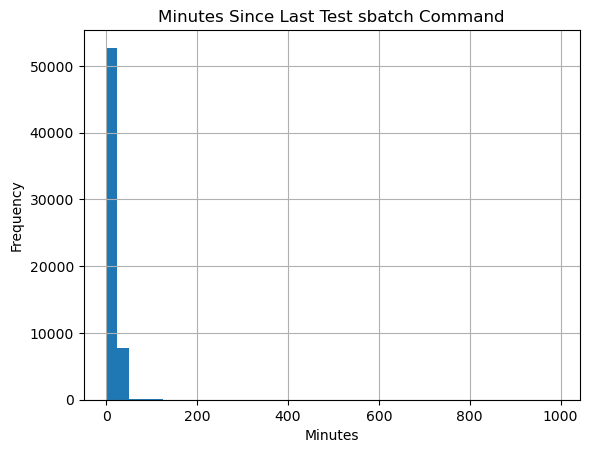

In [28]:
osg_test_sbatch['Time_Diff'].hist(bins=40)
plt.title("Minutes Since Last Test sbatch Command")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

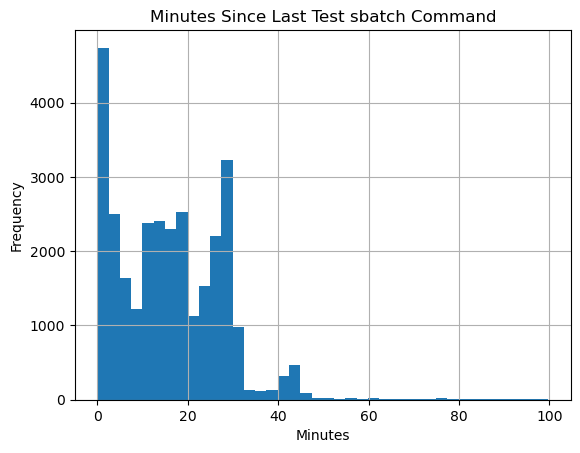

In [29]:
# Excluding outliers and zeros
osg_test_sbatch[(osg_test_sbatch['Time_Diff']<100)&(osg_test_sbatch['Time_Diff']>0)]['Time_Diff'].hist(bins=40)
plt.title("Minutes Since Last Test sbatch Command")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

## 3. Feature Engineering

##### We'll convert the date and time columns to a datetime data type in both fullsample.csv and the CE5/6 slurm logs.

##### Code:

In [30]:
jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'], format = '%Y-%m-%dT%H:%M:%S', errors='coerce')
jobs['END'] = pd.to_datetime(jobs['END'], format = '%Y-%m-%dT%H:%M:%S', errors='coerce')
osg_logs['Date'] = pd.to_datetime(osg_logs['Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

##### Next, we'll filter out all jobs in fullsample.csv that have inconsistent 'USEDTIME' values (e.g. the begin time is after the end time, or the USEDTIME value does not equal the end time minus the begin time).

##### Code:

In [31]:
jobs = jobs[~jobs['JOBID'].isin(inconsistent_usedtime['JOBID'].to_list())]

##### Next we will extract just the job completions from fullsample.csv. These are the jobs that show a "COMPLETED" status with an exit code of 0:0.

##### Code:

In [32]:
job_completions = jobs[
        (jobs['STATE']=='COMPLETED') 
        & (jobs['EXITCODE']=='0:0')]

##### Now we will calculate the number of completed jobs leading up to the end time of each job. We will look at several different intervals.

In [33]:
# First sort by end date
job_completions = job_completions.sort_values('END')

# Calculate number of completed jobs in different time intervals prior to each job's end time
job_completions['Completed_Jobs_5_Min'] = job_completions.rolling(window = '5min', on='END')['JOBID'].count()
job_completions['Completed_Jobs_15_Min'] = job_completions.rolling(window = '15min', on='END')['JOBID'].count()
job_completions['Completed_Jobs_30_Min'] = job_completions.rolling(window = '30min', on='END')['JOBID'].count()
job_completions['Completed_Jobs_1_Hr'] = job_completions.rolling(window = '1h', on='END')['JOBID'].count()

##### Now we'll parse CE5 and CE6 logs to narrow down to just the events where the test user (user 9204) sent an sbatch command (i.e. the command starts with '/usr/bin/sbatch') to the scheduler. 

In [34]:
osg_test_sbatch = osg_logs[(osg_logs['Leading_Command']=='/usr/bin/sbatch')
        & (osg_logs['User']=='9204')].sort_values(by='Date')

osg_test_sbatch.head(2)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch


##### We can now add an indicator column that reflects whether the scheduler was responsive (i.e. the returncode is zero and the time is less than 15) or unresponsive (i.e. the returncode is non-zero and the itme is greater than 15). We will use an indicator of 1 to indicate the scheduler was unresponsive, and 0 to indicate the scheduler was responsive, since we are interested in predicting when the scheduler will be unresponsive. 

In [35]:
osg_test_sbatch['Unresponsive'] = ((osg_test_sbatch['Time'] > 15) & (osg_test_sbatch['Return_Code'] != 0)).astype('int')

In [36]:
osg_test_sbatch.head(2)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Unresponsive
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,0
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,0


##### Next we will merge the slurm logs and ACCRE job completion data. We'll associate each test sbatch command with the ACCRE job that was completed most recently. 

In [106]:
# First sort by command date and job end time
osg_test_sbatch = osg_test_sbatch.sort_values('Date')
job_completions = job_completions.sort_values('END')

# Apply merge_asof to join each test sbatch command with the closest ACCRE job completion

analysis_data = pd.merge_asof(
    osg_test_sbatch, 
    job_completions,
    left_on='Date',
    right_on='END',
)

# Adding a column for the time since the last job completion
analysis_data['Time_Since_Last_Job'] = analysis_data['Date'] - analysis_data['END']

# Adding a column for quantile of Time_Since_Last_Job
analysis_data['Gap_Quantile'] = pd.qcut(analysis_data['Time_Since_Last_Job'], q=10, labels=False)

In [107]:
analysis_data.head(2)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Unresponsive,JOBID,...,NODES,CPUS,PARTITION,EXITCODE,Completed_Jobs_5_Min,Completed_Jobs_15_Min,Completed_Jobs_30_Min,Completed_Jobs_1_Hr,Time_Since_Last_Job,Gap_Quantile
0,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,0,24960943,...,1,1,production,0:0,41.0,105.0,157.0,581.0,0 days 00:00:00.779719,1
1,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,0,24960943,...,1,1,production,0:0,41.0,105.0,157.0,581.0,0 days 00:00:00.779719,1


To make the merged data more accurately model our hypothesis, we need to make sure each test sbatch command is associated with a job that completed very close to the time the command was sent, otherwise our analysis intervals will have too much variance. Let's discard the logs whose distance from the most recent ACCRE job completion is in the top 10% of our data. We will do some simple analysis on the data that we will be losing.

In [109]:
job_completion_analysis_data = analysis_data[analysis_data['Gap_Quantile']<9]

In [123]:
job_completion_analysis_data['Time_Since_Last_Job'].max()

Timedelta('0 days 00:01:02.576296')

We see that by dropping the rows with 'Time_Since_Last_Job' in the top 10%, we are increasing our time intervals by a maximum of about 1 minute and 2 seconds.

In [115]:
overall_hang = analysis_data['Unresponsive'].mean()*100
data_lost_hang = analysis_data[analysis_data['Gap_Quantile']==9]['Unresponsive'].mean()*100
data_kept_hang = analysis_data[analysis_data['Gap_Quantile']<9]['Unresponsive'].mean()*100

In [116]:
print(f'Overall, the scheduler was unresponsive about {overall_hang:.2f}% of the time.')

Overall, the scheduler was unresponsive about 7.44% of the time.


In [117]:
print(f'For the data we are losing, the scheduler was unresponsive about {data_lost_hang:.2f}% of the time.')

For the data we are losing, the scheduler was unresponsive about 22.16% of the time.


In [118]:
print(f'For the data we are keeping, the scheduler was unresponsive about {data_kept_hang:.2f}% of the time.')

For the data we are keeping, the scheduler was unresponsive about 5.80% of the time.


##### Finally, we will add additional features for analysis. For each sbatch command sent by the test user, we will calculate the following:  

* Time of day (morning/afternoon/night) 
* Day of week

In [45]:
# Extract hour from merged_data
analysis_data['Hour'] = analysis_data['Date'].dt.hour

# Define bins and labels 
bins = [0, 4, 11, 17, 24] # midnight to 4 am (Night), 4 am to 11 am (Morning), 11 am to 6 pm (Afternoon), 6 pm to midnight (Night)
labels = ['Night', 'Morning', 'Afternoon', 'Night']

# Apply pd.cut
analysis_data['Time_of_Day'] = pd.cut(analysis_data['Hour'], bins=bins, labels=labels, right=True, ordered=False)

In [46]:
# Extract weekday from date
analysis_data['Day_Of_Week'] = analysis_data['Date'].dt.day_name()

# Add another column for weekday vs weekend
analysis_data['Weekday'] = (analysis_data['Day_Of_Week'].isin(['Saturday','Sunday'])).astype('int')
analysis_data['Weekday'] = analysis_data['Weekday'].replace({1: 'Weekend', 0: 'Weekday'})

In [47]:
analysis_data.head(2)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Unresponsive,JOBID,...,PARTITION,EXITCODE,Completed_Jobs_5_Min,Completed_Jobs_15_Min,Completed_Jobs_30_Min,Completed_Jobs_1_Hr,Hour,Time_of_Day,Day_Of_Week,Weekday
0,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,0,24962765_302,...,production,0:0,40.0,104.0,156.0,580.0,8,Morning,Friday,Weekday
1,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,0,24962765_302,...,production,0:0,40.0,104.0,156.0,580.0,8,Morning,Friday,Weekday


## 4. Analysis & Visualizations  

#### Summary Statistics:

In [48]:
jobs_5min=analysis_data['Completed_Jobs_5_Min'].mean()
print(f'The average number of ACCRE jobs completed in the 5 minutes preceding each test sbatch command was {jobs_5min:.2f} jobs.')

The average number of ACCRE jobs completed in the 5 minutes preceding each test sbatch command was 115.85 jobs.


In [49]:
jobs_15min=analysis_data['Completed_Jobs_15_Min'].mean()
print(f'The average number of ACCRE jobs completed in the 15 minutes preceding each test sbatch command was {jobs_15min:.2f} jobs.')

The average number of ACCRE jobs completed in the 15 minutes preceding each test sbatch command was 323.73 jobs.


In [50]:
jobs_30min=analysis_data['Completed_Jobs_30_Min'].mean()
print(f'The average number of ACCRE jobs completed in the 30 minutes preceding each test sbatch command was {jobs_30min:.2f} jobs.')

The average number of ACCRE jobs completed in the 30 minutes preceding each test sbatch command was 619.06 jobs.


In [51]:
jobs_1hr=analysis_data['Completed_Jobs_1_Hr'].mean()
print(f'The average number of ACCRE jobs completed in the 1 hour preceding each test sbatch command was {jobs_1hr:.2f} jobs.')

The average number of ACCRE jobs completed in the 1 hour preceding each test sbatch command was 1185.07 jobs.


#### Preliminary Visualizations:

##### Distribution of job completions

The distribution of job completions for each time interval looks very similar for each interval. There is a strong right skew with many large outliers, with a very tight left whisker and small box.

###### 5 min interval

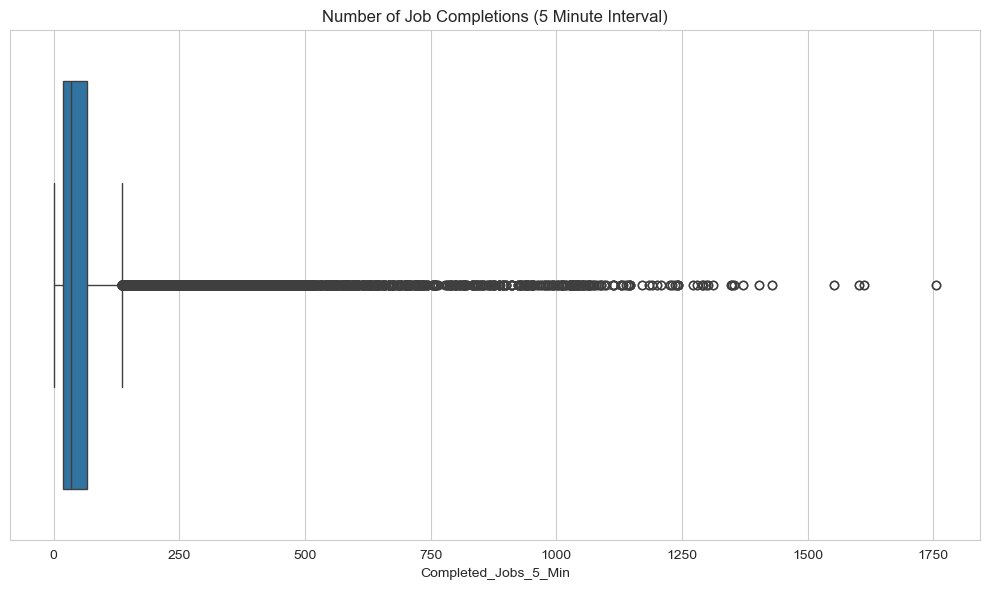

In [124]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Completed_Jobs_5_Min', data = job_completion_analysis_data)
plt.title('Number of Job Completions (5 Minute Interval)');

plt.tight_layout()
plt.show()

###### 15 min interval

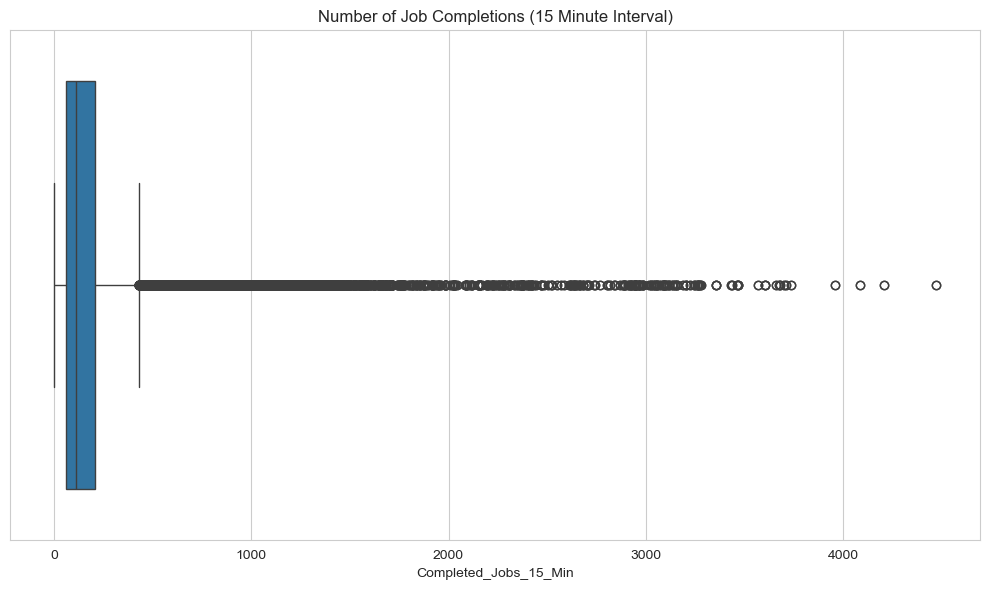

In [125]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Completed_Jobs_15_Min', data = job_completion_analysis_data)
plt.title('Number of Job Completions (15 Minute Interval)');

plt.tight_layout()
plt.show()

###### 30 min interval

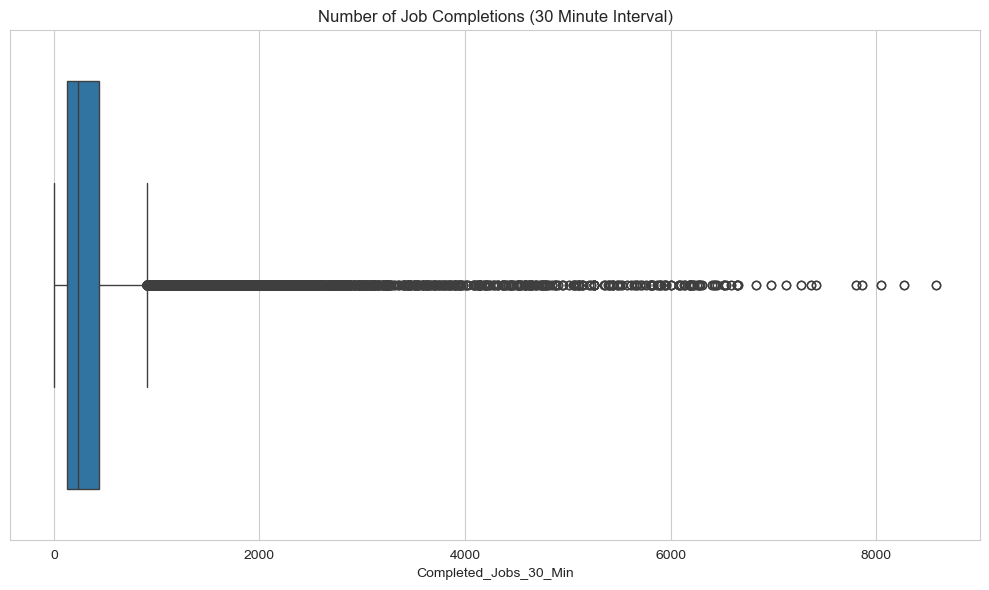

In [126]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Completed_Jobs_30_Min', data = job_completion_analysis_data)
plt.title('Number of Job Completions (30 Minute Interval)');

plt.tight_layout()
plt.show()

###### 1 hr interval

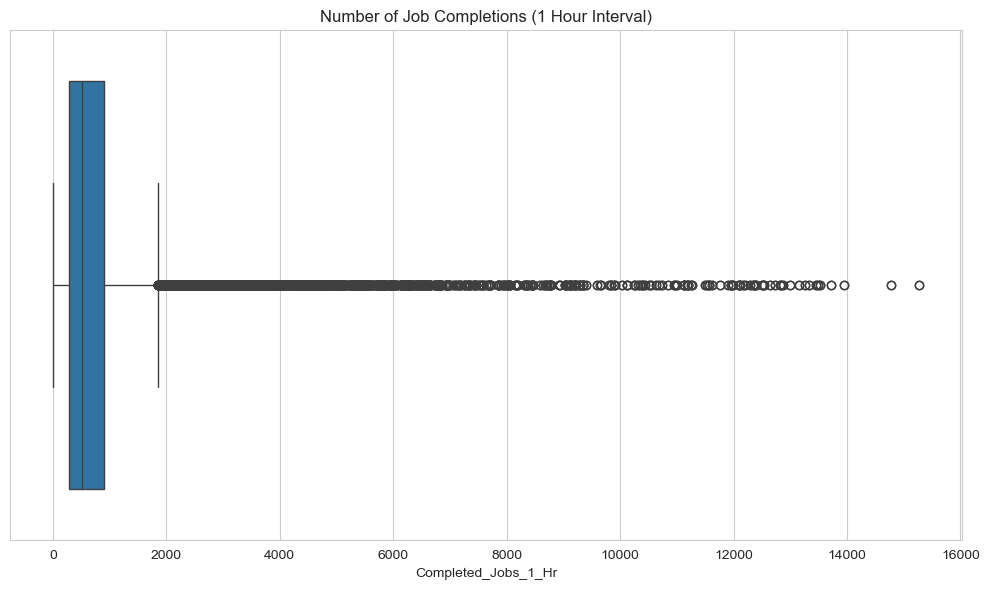

In [127]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Completed_Jobs_1_Hr', data = job_completion_analysis_data)
plt.title('Number of Job Completions (1 Hour Interval)');

plt.tight_layout()
plt.show()

##### Time Series Plots of Scheduler Unresponsiveness

Based on the time series plot below, we see that the average number of scheduler hangs hit its lowest point in June 2021, and peaked around April of 2021. There do not seem to be any obvious time trends in the data.

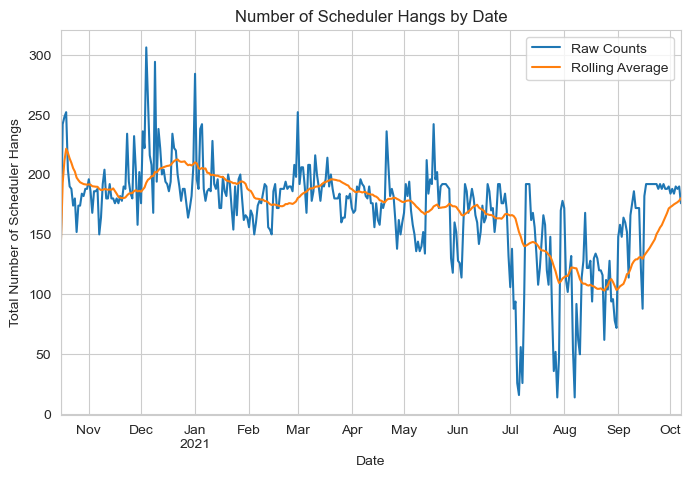

In [56]:
# Creating a date column 
analysis_data['Day'] = analysis_data['Date'].dt.date

num_hangs_by_day = analysis_data.groupby('Day').size().reset_index().sort_values(by='Day')
num_hangs_by_day.columns = ['Day', 'Num_Scheduler_Hangs']
num_hangs_by_day['Day'] = pd.to_datetime(num_hangs_by_day['Day'])
num_hangs_by_day['rolling_30D'] = num_hangs_by_day.rolling(window = '30D', on='Day')['Num_Scheduler_Hangs'].mean()

ax = num_hangs_by_day.plot(x='Day', y='Num_Scheduler_Hangs', label= 'Raw Counts')
num_hangs_by_day.plot(x='Day', y='rolling_30D', label= 'Rolling Average', ax=ax, figsize=(8, 5));

plt.title('Number of Scheduler Hangs by Date')
plt.xlabel('Date')
plt.ylabel('Total Number of Scheduler Hangs')
plt.show()

#### Statistical Modeling:

In [57]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

##### First we will look the relationship between job completions and unresponsiveness using a logistic regression model. We will use several different time windows and compare the resulting models.

###### 5 minute window

In [128]:
resp_jobs_5min_logreg = smf.logit("Unresponsive ~ Completed_Jobs_5_Min",
                          data = job_completion_analysis_data).fit()
resp_jobs_5min_logreg.params

Optimization terminated successfully.
         Current function value: 0.221464
         Iterations 7


Intercept              -2.763358
Completed_Jobs_5_Min   -0.000346
dtype: float64

In [129]:
resp_jobs_5min_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Unresponsive   No. Observations:                54732
Model:                          Logit   Df Residuals:                    54730
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               0.0001942
Time:                        16:59:12   Log-Likelihood:                -12121.
converged:                       True   LL-Null:                       -12124.
Covariance Type:            nonrobust   LLR p-value:                   0.02999
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.7634      0.021   -129.730      0.000      -2.805      -2.722
Completed_Jobs_5_Min    -0.0003      0.000     -2.103      0.035      -0.001   -2.35e-05
========================================================================================
"""

The coefficient for number of completed ACCRE jobs in the last 5 minutes is statistically significant, with a p-value of 0.035, which is less than alpha=0.05.

In [60]:
odds_ratio = np.exp(resp_jobs_5min_logreg.params['Completed_Jobs_5_Min'])

print(f'Each additional ACCRE job that completes in the previous 5 minutes decreases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')

print(f'In other words, each additional ACRE job that completes in the previous 5 minutes increases the odds that the scheduler will be responsive by about {(1-odds_ratio)*100:.2f}%.')


Each additional ACCRE job that completes in the previous 5 minutes decreases the odds that the scheduler will be unresponsive by a factor of 0.9982.
In other words, each additional ACRE job that completes in the previous 5 minutes increases the odds that the scheduler will be responsive by about 0.18%.


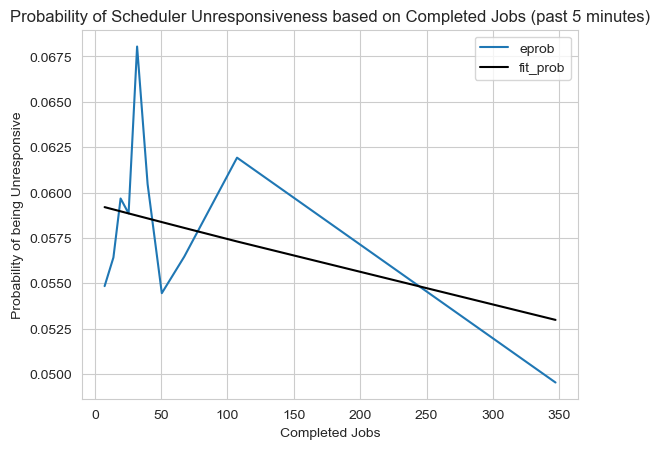

In [130]:
resp_summary = (
    job_completion_analysis_data
    .assign(group = pd.qcut(job_completion_analysis_data['Completed_Jobs_5_Min'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Completed_Jobs_5_Min', 'Unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'Unresponsive': 'eprob'})
)

resp_summary['fit_prob'] = resp_jobs_5min_logreg.predict(resp_summary[['Completed_Jobs_5_Min']])

ax = resp_summary.plot(x = 'Completed_Jobs_5_Min', y = 'eprob')
resp_summary.plot(x = 'Completed_Jobs_5_Min', y = 'fit_prob',
                color = 'black',
                ax = ax)
plt.title("Probability of Scheduler Unresponsiveness based on Completed Jobs (past 5 minutes)")
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of being Unresponsive");

###### 15 minute window

In [131]:
resp_jobs_15min_logreg = smf.logit("Unresponsive ~ Completed_Jobs_15_Min",
                          data = job_completion_analysis_data).fit()
resp_jobs_15min_logreg.params

Optimization terminated successfully.
         Current function value: 0.221506
         Iterations 7


Intercept               -2.782277
Completed_Jobs_15_Min   -0.000023
dtype: float64

In [132]:
resp_jobs_15min_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Unresponsive   No. Observations:                54732
Model:                          Logit   Df Residuals:                    54730
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               6.837e-06
Time:                        16:59:32   Log-Likelihood:                -12123.
converged:                       True   LL-Null:                       -12124.
Covariance Type:            nonrobust   LLR p-value:                    0.6839
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.7823      0.022   -128.126      0.000      -2.825      -2.740
Completed_Jobs_15_Min   -2.3e-05   5.68e-05     -0.405      0.686      -0.000    8.83e-05
=========================================================================================
"""

The coefficient for number of completed ACCRE jobs in the last 15 minutes is not statistically significant, with a p-value of 0.686, which is greater than alpha=0.05.

In [146]:
odds_ratio = np.exp(resp_jobs_15min_logreg.params['Completed_Jobs_15_Min'])

print(f'Each additional ACCRE job that completes in the previous 15 minutes decreases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f} (i.e. no effect).')


Each additional ACCRE job that completes in the previous 15 minutes decreases the odds that the scheduler will be unresponsive by a factor of 1.0000 (i.e. no effect).


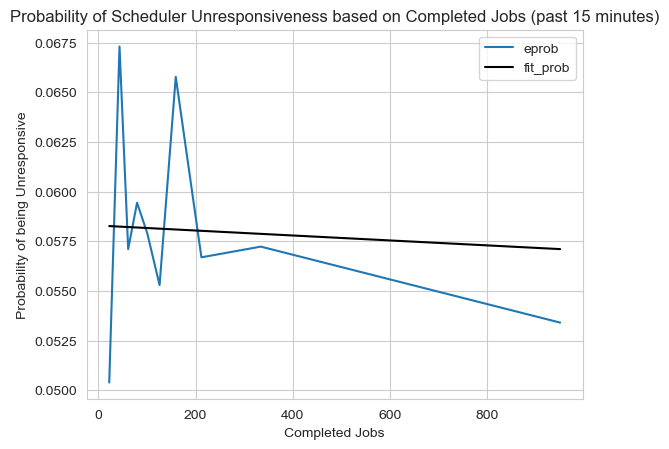

In [134]:
resp_summary = (
    job_completion_analysis_data
    .assign(group = pd.qcut(job_completion_analysis_data['Completed_Jobs_15_Min'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Completed_Jobs_15_Min', 'Unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'Unresponsive': 'eprob'})
)

resp_summary['fit_prob'] = resp_jobs_15min_logreg.predict(resp_summary[['Completed_Jobs_15_Min']])

ax = resp_summary.plot(x = 'Completed_Jobs_15_Min', y = 'eprob')
resp_summary.plot(x = 'Completed_Jobs_15_Min', y = 'fit_prob',
                color = 'black',
                ax = ax)
plt.title("Probability of Scheduler Unresponsiveness based on Completed Jobs (past 15 minutes)")
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of being Unresponsive");

###### 30 minute window

In [135]:
resp_jobs_30min_logreg = smf.logit("Unresponsive ~ Completed_Jobs_30_Min",
                          data = job_completion_analysis_data).fit()
resp_jobs_30min_logreg.params

Optimization terminated successfully.
         Current function value: 0.221507
         Iterations 7


Intercept               -2.783910
Completed_Jobs_30_Min   -0.000008
dtype: float64

In [136]:
resp_jobs_30min_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Unresponsive   No. Observations:                54732
Model:                          Logit   Df Residuals:                    54730
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               2.588e-06
Time:                        17:00:11   Log-Likelihood:                -12124.
converged:                       True   LL-Null:                       -12124.
Covariance Type:            nonrobust   LLR p-value:                    0.8022
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.7839      0.022   -125.619      0.000      -2.827      -2.740
Completed_Jobs_30_Min -7.582e-06   3.04e-05     -0.250      0.803   -6.71e-05    5.19e-05
=========================================================================================
"""

The coefficient for number of completed ACCRE jobs in the last 30 minutes is not statistically significant, with a p-value of 0.803, which is greater than alpha=0.05.

In [145]:
odds_ratio = np.exp(resp_jobs_30min_logreg.params['Completed_Jobs_30_Min'])

print(f'Each additional ACCRE job that completes in the previous 30 minutes decreases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f} (i.e. no effect).')


Each additional ACCRE job that completes in the previous 30 minutes decreases the odds that the scheduler will be unresponsive by a factor of 1.0000 (i.e. no effect).


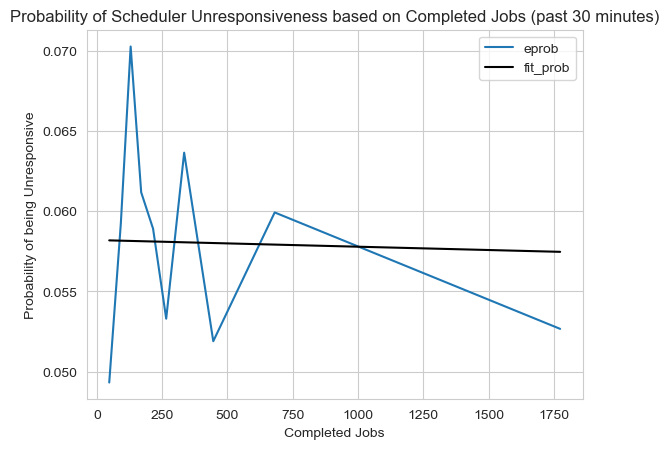

In [138]:
resp_summary = (
    job_completion_analysis_data
    .assign(group = pd.qcut(job_completion_analysis_data['Completed_Jobs_30_Min'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Completed_Jobs_30_Min', 'Unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'Unresponsive': 'eprob'})
)

resp_summary['fit_prob'] = resp_jobs_30min_logreg.predict(resp_summary[['Completed_Jobs_30_Min']])

ax = resp_summary.plot(x = 'Completed_Jobs_30_Min', y = 'eprob')
resp_summary.plot(x = 'Completed_Jobs_30_Min', y = 'fit_prob',
                color = 'black',
                ax = ax)
plt.title("Probability of Scheduler Unresponsiveness based on Completed Jobs (past 30 minutes)")
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of being Unresponsive");

###### 1 hour window

In [139]:
resp_jobs_1hr_logreg = smf.logit("Unresponsive ~ Completed_Jobs_1_Hr",
                          data = job_completion_analysis_data).fit()
resp_jobs_1hr_logreg.params

Optimization terminated successfully.
         Current function value: 0.221492
         Iterations 7


Intercept             -2.769151
Completed_Jobs_1_Hr   -0.000022
dtype: float64

In [140]:
resp_jobs_1hr_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Unresponsive   No. Observations:                54732
Model:                          Logit   Df Residuals:                    54730
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               6.975e-05
Time:                        17:00:51   Log-Likelihood:                -12123.
converged:                       True   LL-Null:                       -12124.
Covariance Type:            nonrobust   LLR p-value:                    0.1934
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.7692      0.023   -120.868      0.000      -2.814      -2.724
Completed_Jobs_1_Hr -2.199e-05   1.72e-05     -1.278      0.201   -5.57e-05    1.17e-05
=======================================================================================
"""

The coefficient for number of completed ACCRE jobs in the last hour is not statistically significant, with a p-value of 0.201, which is greater than alpha=0.05.

In [144]:
odds_ratio = np.exp(resp_jobs_1hr_logreg.params['Completed_Jobs_1_Hr'])

print(f'Each additional ACCRE job that completes in the previous hour decreases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f} (i.e. no effect).')


Each additional ACCRE job that completes in the previous hour decreases the odds that the scheduler will be unresponsive by a factor of 1.0000 (i.e. no effect).


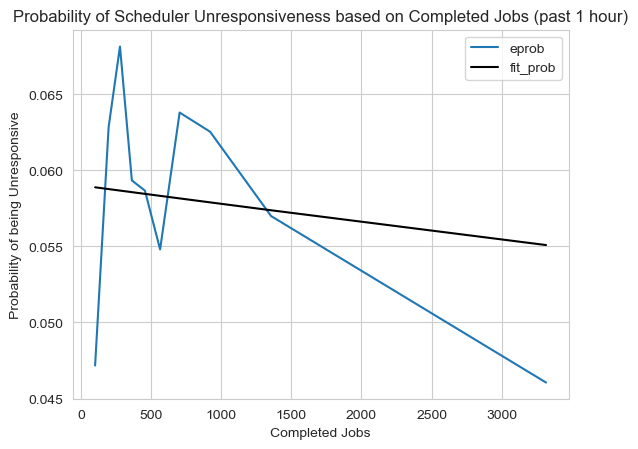

In [142]:
resp_summary = (
    job_completion_analysis_data
    .assign(group = pd.qcut(job_completion_analysis_data['Completed_Jobs_1_Hr'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Completed_Jobs_1_Hr', 'Unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'Unresponsive': 'eprob'})
)

resp_summary['fit_prob'] = resp_jobs_1hr_logreg.predict(resp_summary[['Completed_Jobs_1_Hr']])

ax = resp_summary.plot(x = 'Completed_Jobs_1_Hr', y = 'eprob')
resp_summary.plot(x = 'Completed_Jobs_1_Hr', y = 'fit_prob',
                color = 'black',
                ax = ax)
plt.title("Probability of Scheduler Unresponsiveness based on Completed Jobs (past 1 hour)")
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of being Unresponsive");

##### We will examine the relationship between day of the week and scheduler unresponsiveness.

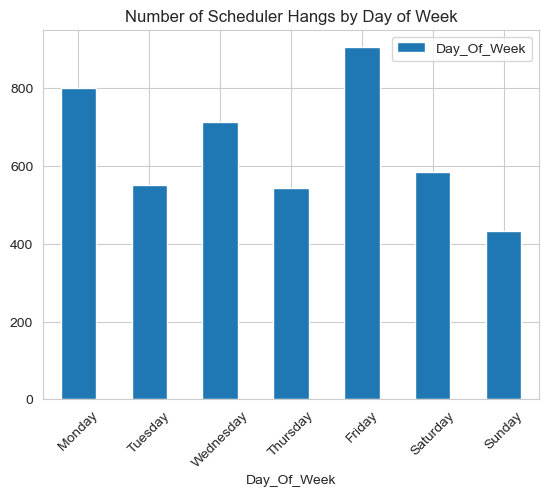

In [74]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
analysis_data[analysis_data['Unresponsive']==1].groupby('Day_Of_Week').agg({'Day_Of_Week':'count'}).reindex(cats) .plot(kind='bar', rot=45)
plt.title('Number of Scheduler Hangs by Day of Week');

We will use Sunday as the reference in our logistic regression model since it is the weekday with the lowest number of scheduler hangs.

In [75]:
resp_dayofweek_logreg = smf.logit("Unresponsive ~ C(Day_Of_Week, Treatment(reference='Sunday'))",
                          data = analysis_data).fit()
resp_dayofweek_logreg.params

Optimization terminated successfully.
         Current function value: 0.262779
         Iterations 7


Intercept                                                    -2.959673
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Friday]       0.782561
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Monday]       0.660343
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Saturday]     0.323065
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Thursday]     0.259526
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Tuesday]      0.309252
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Wednesday]    0.540804
dtype: float64

In [76]:
odds_ratio = np.exp(resp_dayofweek_logreg.params["C(Day_Of_Week, Treatment(reference='Sunday'))[T.Monday]"])

print(f'A command being sent on Monday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')


A command being sent on Monday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of 1.9355.


In [77]:
odds_ratio = np.exp(resp_dayofweek_logreg.params["C(Day_Of_Week, Treatment(reference='Sunday'))[T.Wednesday]"])

print(f'A command being sent on Wednesday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')


A command being sent on Wednesday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of 1.7174.


In [78]:
odds_ratio = np.exp(resp_dayofweek_logreg.params["C(Day_Of_Week, Treatment(reference='Sunday'))[T.Friday]"])

print(f'A command being sent on Friday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')


A command being sent on Friday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of 2.1871.


In [79]:
odds_ratio = np.exp(resp_dayofweek_logreg.params["C(Day_Of_Week, Treatment(reference='Sunday'))[T.Saturday]"])

print(f'A command being sent on Saturday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')

A command being sent on Saturday (as opposed to Sunday) increases the odds that the scheduler will be unresponsive by a factor of 1.3814.


In [80]:
resp_dayofweek_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Unresponsive   No. Observations:                60814
Model:                          Logit   Df Residuals:                    60807
Method:                           MLE   Df Model:                            6
Date:                Sun, 14 Dec 2025   Pseudo R-squ.:                0.007823
Time:                        23:00:53   Log-Likelihood:                -15981.
converged:                       True   LL-Null:                       -16107.
Covariance Type:            nonrobust   LLR p-value:                 1.529e-51
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -2.9597      0.049    -59.981      0.000      -3.056      -2.863
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Friday]        0.7826      0.061     12.924      0.000       0.664       0.901
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Monday]        0.6603      0.062     10.698      0.000       0.539       0.781
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Saturday]      0.3231      0.065      4.944      0.000       0.195       0.451
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Thursday]      0.2595      0.066      3.911      0.000       0.129       0.390
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Tuesday]       0.3093      0.066      4.672      0.000       0.180       0.439
C(Day_Of_Week, Treatment(reference='Sunday'))[T.Wednesday]     0.5408      0.063      8.589      0.000       0.417       0.664
==============================================================================================================================
"""

Applying the Bonferroni correction, we will use an alpha value of 0.05/7 $\approx$ 0.007.

After applying the Bonferroni correction, all of the model's coefficients are statistically significant. 

##### Next we will look at the relationship between weekday/weekend and unresponsiveness using a logistic regression model.

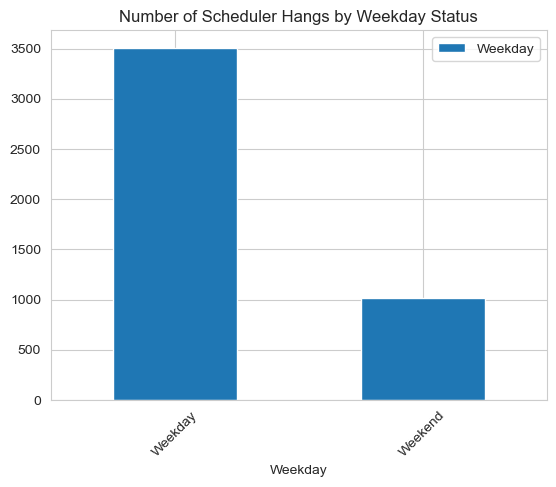

In [81]:
cats = ['Weekday','Weekend']
analysis_data[analysis_data['Unresponsive']==1].groupby('Weekday').agg({'Weekday':'count'}).reindex(cats) .plot(kind='bar', rot=45)
plt.title('Number of Scheduler Hangs by Weekday Status');

In [82]:
resp_weekday_logreg = smf.logit("Unresponsive ~ C(Weekday, Treatment(reference='Weekend'))",
                          data = analysis_data).fit()
resp_weekday_logreg.params

Optimization terminated successfully.
         Current function value: 0.264030
         Iterations 7


Intercept                                               -2.786881
C(Weekday, Treatment(reference='Weekend'))[T.Weekday]    0.358060
dtype: float64

In [83]:
odds_ratio = np.exp(resp_weekday_logreg.params["C(Weekday, Treatment(reference='Weekend'))[T.Weekday]"])

print(f'A command being sent on a weekday (as opposed to a weekend) increases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')

A command being sent on a weekday (as opposed to a weekend) increases the odds that the scheduler will be unresponsive by a factor of 1.4306.


In [84]:
resp_weekday_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Unresponsive   No. Observations:                60814
Model:                          Logit   Df Residuals:                    60812
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Dec 2025   Pseudo R-squ.:                0.003102
Time:                        23:00:54   Log-Likelihood:                -16057.
converged:                       True   LL-Null:                       -16107.
Covariance Type:            nonrobust   LLR p-value:                 1.581e-23
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -2.7869      0.032    -86.215      0.000      -2.850      -2.724
C(Weekday, Treatment(reference='Weekend'))[T.Weekday]     0.3581      0.037      9.727      0.000       0.286       0.430
=========================================================================================================================
"""

The coefficient for weekday is statistically significant, with a p-value of 0, which is less than alpha=0.05.

##### We will also look at the effect of time of day on scheduler unresponsiveness.

/var/folders/51/zgq0lbb14t13h0_bgn8nntnm0000gn/T/ipykernel_59285/3751382944.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_data[analysis_data['Unresponsive']==1].groupby('Time_of_Day').agg({'Time_of_Day':'count'}).reindex(cats).plot(kind='bar', rot=45)


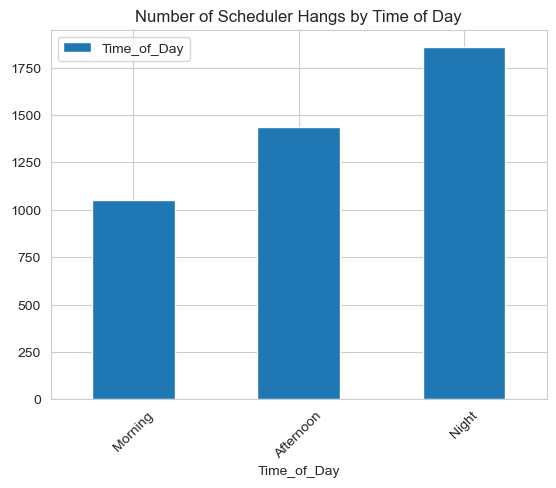

In [85]:
cats = ['Morning','Afternoon','Night']
analysis_data[analysis_data['Unresponsive']==1].groupby('Time_of_Day').agg({'Time_of_Day':'count'}).reindex(cats).plot(kind='bar', rot=45)
plt.title('Number of Scheduler Hangs by Time of Day');

In [86]:
resp_time_of_day_logreg = smf.logit("Unresponsive ~ C(Time_of_Day, Treatment(reference='Morning'))", data = analysis_data).fit()
resp_time_of_day_logreg.params

Optimization terminated successfully.
         Current function value: 0.264202
         Iterations 7


Intercept                                                     -2.742801
C(Time_of_Day, Treatment(reference='Morning'))[T.Afternoon]    0.456668
C(Time_of_Day, Treatment(reference='Morning'))[T.Night]        0.205757
dtype: float64

In [87]:
odds_ratio = np.exp(resp_time_of_day_logreg.params["C(Time_of_Day, Treatment(reference='Morning'))[T.Afternoon]"])

print(f'A command being sent in the afternoon (as opposed to morning) increases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')


A command being sent in the afternoon (as opposed to morning) increases the odds that the scheduler will be unresponsive by a factor of 1.5788.


In [88]:
odds_ratio = np.exp(resp_time_of_day_logreg.params["C(Time_of_Day, Treatment(reference='Morning'))[T.Night]"])

print(f'A command being sent during the night (as opposed to morning) increases the odds that the scheduler will be unresponsive by a factor of {odds_ratio:.4f}.')


A command being sent during the night (as opposed to morning) increases the odds that the scheduler will be unresponsive by a factor of 1.2285.


In [89]:
resp_time_of_day_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Unresponsive   No. Observations:                58250
Model:                          Logit   Df Residuals:                    58247
Method:                           MLE   Df Model:                            2
Date:                Sun, 14 Dec 2025   Pseudo R-squ.:                0.003875
Time:                        23:00:54   Log-Likelihood:                -15390.
converged:                       True   LL-Null:                       -15450.
Covariance Type:            nonrobust   LLR p-value:                 1.003e-26
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -2.7428      0.032    -86.229      0.000      -2.805      -2.680
C(Time_of_Day, Treatment(reference='Morning'))[T.Afternoon]     0.4567      0.042     10.824      0.000       0.374       0.539
C(Time_of_Day, Treatment(reference='Morning'))[T.Night]         0.2058      0.040      5.155      0.000       0.128       0.284
===============================================================================================================================
"""

Applying the Bonferroni correction, we will use an alpha value of 0.05/3 $\approx$ 0.0167.

After applying the Bonferroni correction, the coefficients for time of day are statistically significant.

## 5. Interpretation & Conclusion

The data weakly supports the hypothesis that the slurm scheduler is more likely to be unresponsive during bursts of job completions. This conclusion was only statistically significant for the 5 minute time interval, not for the 15 minute, 30 minute, or 1 hour time intervals. However, the size of the effect for the 5 minute window is small; for example, each 10 additional ACCRE jobs that complete in a 5 minute interval increases the odds that the scheduler will be responsive by about 1.8%.

We do see statistically significant effects on scheduler responsiveness based on the weekday, time of day, and weekday/weekend status. A command being sent in the afternoon (as opposed to morning) increases the odds that the scheduler will be unresponsive by over 50%. A command being sent on a weekday (as opposed to a weekend) increases the odds that the scheduler will be unresponsive by 43%; furthermore, a command being sent on a Friday (as opposed to a Sunday) doubles the odds that the scheduler will be unresponsive.

There were some limitations in the way our data analysis was conducted. Based on the way we merged the ACCRE job completion data into the slurm log dataset, we lost 10% of the slurm job scheduler data. The frequency of unresponsiveness was much greater among the data that was discarded compared with the overall frequency, which might have affected the results of the statistical tests that use job completions as the explanatory variable. In addition, based on the way we merged our datasets, each time interval we examined was not exact for every single slurm log; for example, an interval that was labeled as a 5-minute interval in our analysis might have been as large as a 6 minute and 2 second interval in reality.